In [1]:
from azure.quantum import Workspace
workspace = Workspace (
    subscription_id = "33e6f75e-0499-425c-8b7d-9f593dde82b6",
    resource_group = "aqet",
    name = "chem560",
    location = "westus"
)


ModuleNotFoundError: No module named 'azure'

In [2]:
!pip install pylatexenc

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 KB 3.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... - done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136835 sha256=f1fad06240c629107b612002a437fa69048a6ecacad5c5e486440c7793b83264
  Stored in directory: /home/jovyan/.cache/pip/wheels/f1/8a/f5/33ee79d4473eb201b519fa40f989b842e373237395a3421f52
Successfully built pylatexenc
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


# Quantum Minesweeper Game
The following is a Quantum Minesweeper Game published by Maria Violaris, a PhD student at the University of Oxford, in 
her [Qiskit post available here](https://medium.com/qiskit/building-quantum-bomb-testers-and-other-thought-experiments-with-quantum-computers-c160060fdde4)

Imagine you are given a box and you can't see what's inside. All you know is that it is either empty, or it contains a highly sensitive bomb. If this bomb is hit by even a single photon, it will explode. Your challenge is to work out whether or not there is a bomb in the box, without exploding it.

Classically, this is impossible. As soon as you try to detect the bomb, it will interact with your detector and explode. But in 1993, quantum physicists Avshalom Elitzur and Lev Vaidman proposed a quantum bomb tester, which allows us to see a bomb without looking.

I'm now going to show you how we can present this controversial bomb tester as a simple quantum circuit, which you can experiment with yourself using Qiskit!

Let's start with a qubit to represent our photon and a qubit to represent our bomb.

When a photon reaches a beam-splitter, it enters a superposition of two paths. This is equivalent to a Hadamard gate, which transforms a qubit from the |0> state to |0> + |1>.

Then our bomb can be represented by a C-NOT gate. If the photon qubit is 0, the bomb qubit stays in the unexploded 0 state. If the photon qubit is 1, the bomb qubit is flipped to a 1, and the bomb has exploded.

Finally our second beamsplitter is just another hadamard gate on the photon qubit. When we run our circuit, we see four outcomes, all with a quarter probability. The one we want is when the photon qubit is 1 but the bomb qubit is 0, so we know the C-NOT gate was there, but the bomb qubit hasn't been flipped.

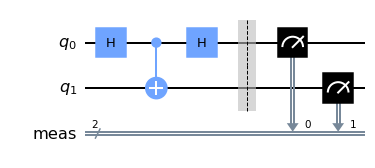

In [2]:
# Code for the basic bomb tester circuit

from qiskit import QuantumCircuit

bomb_tester = QuantumCircuit(2)
bomb_tester.h(0)
bomb_tester.cx(0, 1)
bomb_tester.h(0)
bomb_tester.measure_all()
bomb_tester.draw(output='mpl')

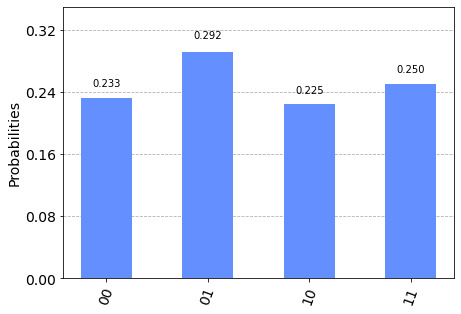

In [3]:
# Running the basic bomb tester circuit

from qiskit.providers.aer import QasmSimulator
simulator = QasmSimulator()

job = simulator.run(bomb_tester, shots=1000)
result = job.result()
counts = result.get_counts(bomb_tester)

from qiskit.visualization import plot_histogram
plot_histogram(counts)

We can make our bomb tester up to 100% effective using the "Quantum Zeno Effect." We adjust our beamsplitter so it has a very high reflectance, meaning that the photon is very likely to collapse in the path with no bomb. If we send the same photon through the beamsplitter lots of times, then the photon is likely collapse into the reflected path every time. But if there is no bomb, then the photon's state gradually changes until it is fully transmitted by the beamsplitter. So we know if the photon ends up reflected, then there is a bomb, without it exploding.

We can code our mostly reflecting beamsplitter with an x-rotation gate in qiskit. The more cycles we add, the more likely we are to detect the bomb without exploding it, meaning the photon qubit is an unchanged 0, and the bomb qubit is always an unexploded 0. In my circuit, I use new C-NOT gates to simulate the photon passing through the bomb tester multiple times. Each time, we measure to check if the bomb has exploded, and then reset the qubit back to zero.

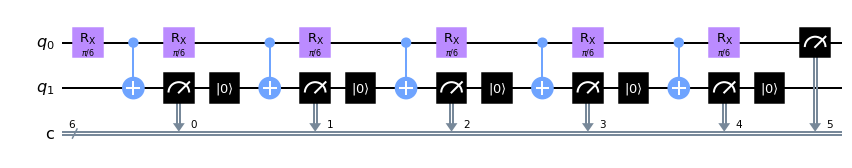

In [4]:
# Coding the Zeno bomb tester 

from qiskit.circuit import QuantumRegister, ClassicalRegister
import numpy as np
from qiskit.circuit.library import RXGate

cycles = 6 # Choose the number of times we want to pass our photon through the mystery box. The more, the better. 
theta = np.pi/cycles # The correct reflectivity of our beamsplitter is chosen for the quantum Zeno effect to work.

# Create our quantum circuit 
qr = QuantumRegister(2, 'q')
cr = ClassicalRegister(cycles, 'c')
zeno_tester = QuantumCircuit(qr, cr)

# Create a chain of our variable beamsplitters and C-NOT bombs 
for cycle in range(cycles-1):
    zeno_tester.append(RXGate(theta), [qr[0]])
    zeno_tester.cx(0, 1)
    zeno_tester.measure(qr[1],cr[cycle])
    zeno_tester.reset(qr[1])

# Add a final beamsplitter
zeno_tester.append(RXGate(theta), [qr[0]])

#Measure our photon to predict whether there is a bomb, and measure our bomb qubit to see if it exploded.    
zeno_tester.measure(qr[0],cr[cycles-1])
zeno_tester.draw(output='mpl')

When we run this bomb tester with six beamsplitters, we now have a 2/3 chance of detecting the bomb without it exploding.

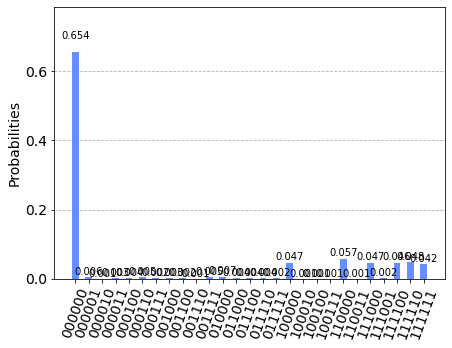

In [5]:
# Running the Zeno bomb tester 

zeno_job = simulator.run(zeno_tester, shots=1000)
zeno_result = zeno_job.result()
zeno_counts = zeno_result.get_counts(zeno_tester)

plot_histogram(zeno_counts)

I've used this bomb tester in my game of Quantum Minesweeper. For my game, I wanted a random way of deciding whether or not the bomb is in the box.

Since my bomb is a C-NOT gate, I added another control to the C-NOT, and put the control qubit in a superposition of 0 and 1, so the bomb is in a superposition of being there and not being there. By measuring this control qubit, I collapse the state find out whether or not the bomb was there, and check it against my prediction from the bomb tester. So my game uses a quantum bomb tester on a quantum bomb!

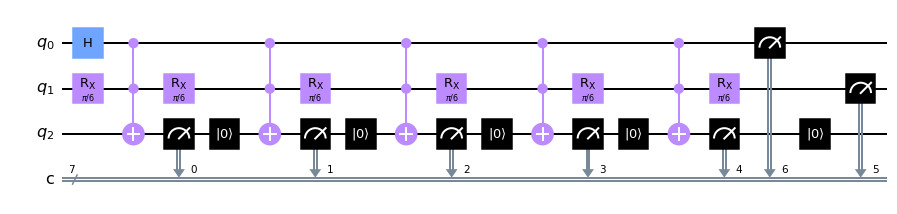

In [6]:
# Setting up the circuit for quantum minesweeper 

from qiskit.circuit.library import CCXGate

def q_sweeper(cycles) -> QuantumCircuit:
    qr = QuantumRegister(3, 'q')
    cr = ClassicalRegister(cycles+1, 'c')
    qc = QuantumCircuit(qr, cr)
    qc.h(qr[0])
    for cycle in range(cycles-1):
        qc.append(RXGate(theta), [qr[1]])
        qc.ccx(qr[0], qr[1], qr[2]) 
        qc.measure(qr[2],cr[cycle])
        if cycle < cycles-1:
            qc.reset(qr[2])
        
    qc.append(RXGate(theta), [qr[1]])
    qc.measure(qr[1],cr[cycles-1])
    qc.measure(qr[0],cr[cycles])
    return qc

successes = 0 # We will use this variable to track the number of successful predictions in a row
cycles = 6
theta = np.pi/cycles

zeno_circuit = q_sweeper(cycles)
zeno_circuit.draw(output='mpl')

Looking at the histogram of outcomes for this circuit, the two most likely outcomes are where I've correctly predicted there is no bomb, or predicted the bomb is there without it exploding. The rest of the time, the bomb explodes.

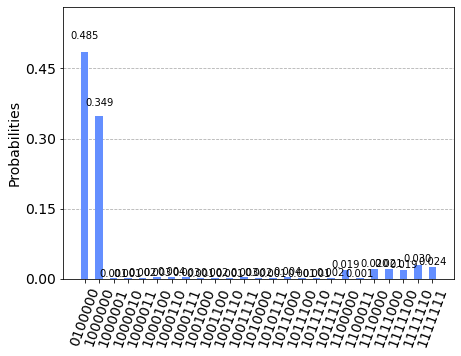

In [7]:
qsweeper_job = simulator.run(zeno_circuit, shots=1000)
qsweeper_result = qsweeper_job.result()
qsweeper_counts = qsweeper_result.get_counts(zeno_circuit)

plot_histogram(qsweeper_counts)

Now you can have a go at quantum minesweeper with six beamsplitters. My highscore is 8 — can you beat it?

In [18]:
# Game of quantum minesweeper 
qsweeper_job = simulator.run(zeno_circuit, shots=1)
qsweeper_result = qsweeper_job.result()
qsweeper_counts = qsweeper_result.get_counts(zeno_circuit)

result = sorted(qsweeper_counts.keys())[0]

for i in range(2,cycles): # Check that none of the 3rd to last bits have flipped to a 1 
    if int(result[i]) == 1:
        print("BOOM! The bomb has exploded. You lose... :(")
        print("Your score was:") 
        print(successes)
        successes = 0
        explode = 1
        break
    else:
        explode = 0
    
if explode == 0:
    print("The qubit predicts...")
    if int(result[1]) == 0:
        print("Bomb present")
        Prediction = input("What do you think? Type 0 for no bomb, 1 for bomb.")
    else:
        print("No bomb")
        Prediction = input("What do you think? Type 0 for no bomb, 1 for bomb.")
        
    if Prediction == "0": 
        print("You predicted there is no bomb.")
    elif Prediction == "1":
        print("You predicted there is a bomb")
    else:
        print("Invalid prediction!")

    if Prediction == result[0]:
        print("Congratulations! You predicted correctly, you win Quantum Minesweeper! :D")
        successes += 1
    elif int(Prediction) == (int(result[0]) + 1) % 2:
        print("Uh oh! You predicted wrong. You lose :(")
        print("Your score was:") 
        print(successes)
        successes = 0
    else:
        print("Prediction was invalid so your score is unchanged.")
    
print("Quantum Minesweeper score:")
print(successes)


The qubit predicts...
Bomb present


If we play this on actual quantum hardware, the more gates we add to our bomb tester, the more disruptive noise we add. (You can find out more about noise in this Qiskit video: https://www.youtube.com/watch?v=yuDxHJOKsVA&t=159s).

I'm going to leave you with a challenge - what is the best bomb tester you can make on real IBM quantum hardware? Let us know how you do in the comments of our quantum bomb-tester YouTube video, which you can view on the Qiskit YouTube channel (https://www.youtube.com/watch?v=fus1nJ6JaTk).

Now you know how to see a bomb without looking and how this paradox turns into a simple quantum circuit! Have fun testing your own quantum bombs.